In [1]:
# !pip install transformers
# !pip install diffusers
# !pip install folium==0.9.1
# !pip install huggingface-hub
# !pip install pillow==9.0.0
# !pip install scikit-image==0.19.2
# !pip install accelerate
# !pip install safetensors
# !pip install sentencepiece
# !pip install -U xformers

In [2]:
# from google.colab import output
# output.enable_custom_widget_manager()

Fix the path so it works with the Reduce, Reuse, Recycle library

In [3]:
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

PATH_NOTEBOOK = Path("").resolve()
RRR_PATH = PATH_NOTEBOOK.parent
# print(RRR_PATH)
sys.path.append(RRR_PATH.as_posix())


In [4]:
"""
    file copy from diffusion library from Huggingface: https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/safety_checker.py
"""
import numpy as np
import torch
import torch.nn as nn

from transformers import CLIPConfig, CLIPVisionModel, PreTrainedModel

from diffusers.utils import logging

logger = logging.get_logger(__name__)


def cosine_distance(image_embeds, text_embeds):
    normalized_image_embeds = nn.functional.normalize(image_embeds)
    normalized_text_embeds = nn.functional.normalize(text_embeds)
    return torch.mm(normalized_image_embeds, normalized_text_embeds.t())


class IFSafetyChecker(PreTrainedModel):
    config_class = CLIPConfig

    _no_split_modules = ["CLIPEncoderLayer"]

    def __init__(self, config: CLIPConfig):
        super().__init__(config)

        self.vision_model = CLIPVisionModelWithProjection(config.vision_config)

        self.p_head = nn.Linear(config.vision_config.projection_dim, 1)
        self.w_head = nn.Linear(config.vision_config.projection_dim, 1)

    @torch.no_grad()
    def forward(self, clip_input, images, p_threshold=0.5, w_threshold=0.5):
        image_embeds = self.vision_model(clip_input)[0]

        nsfw_detected = self.p_head(image_embeds)
        nsfw_detected = nsfw_detected.flatten()
        nsfw_detected = nsfw_detected > p_threshold
        nsfw_detected = nsfw_detected.tolist()

        if any(nsfw_detected):
            logger.warning(
                "Potential NSFW content was detected in one or more images. A black image will be returned instead."
                " Try again with a different prompt and/or seed.")

        for idx, nsfw_detected_ in enumerate(nsfw_detected):
            if nsfw_detected_:
                images[idx] = np.zeros(images[idx].shape)

        watermark_detected = self.w_head(image_embeds)
        watermark_detected = watermark_detected.flatten()
        watermark_detected = watermark_detected > w_threshold
        watermark_detected = watermark_detected.tolist()

        if any(watermark_detected):
            logger.warning(
                "Potential watermarked content was detected in one or more images. A black image will be returned instead."
                " Try again with a different prompt and/or seed.")

        for idx, watermark_detected_ in enumerate(watermark_detected):
            if watermark_detected_:
                images[idx] = np.zeros(images[idx].shape)

        return images, nsfw_detected, watermark_detected

In [5]:
from typing import List

import PIL
import torch
from PIL import Image

from diffusers.configuration_utils import ConfigMixin
from diffusers.models.modeling_utils import ModelMixin
from diffusers.utils import PIL_INTERPOLATION


class IFWatermarker(ModelMixin, ConfigMixin):

    def __init__(self):
        super().__init__()

        self.register_buffer("watermark_image", torch.zeros((62, 62, 4)))
        self.watermark_image_as_pil = None

    def apply_watermark(self, images: List[PIL.Image.Image], sample_size=None):
        # copied from https://github.com/deep-floyd/IF/blob/b77482e36ca2031cb94dbca1001fc1e6400bf4ab/deepfloyd_if/modules/base.py#L287

        h = images[0].height
        w = images[0].width

        sample_size = sample_size or h

        coef = min(h / sample_size, w / sample_size)
        img_h, img_w = (int(h / coef), int(w / coef)) if coef < 1 else (h, w)

        S1, S2 = 1024**2, img_w * img_h
        K = (S2 / S1)**0.5
        wm_size, wm_x, wm_y = int(K * 62), img_w - int(14 * K), img_h - int(14 * K)

        if self.watermark_image_as_pil is None:
            watermark_image = self.watermark_image.to(torch.uint8).cpu().numpy()
            watermark_image = Image.fromarray(watermark_image, mode="RGBA")
            self.watermark_image_as_pil = watermark_image

        wm_img = self.watermark_image_as_pil.resize((wm_size, wm_size),
                                                    PIL_INTERPOLATION["bicubic"],
                                                    reducing_gap=None)

        for pil_img in images:
            pil_img.paste(wm_img,
                          box=(wm_x - wm_size, wm_y - wm_size, wm_x, wm_y),
                          mask=wm_img.split()[-1])

        return images

In [6]:
"""
A codebase for performing model inference with a text-conditional diffusion model.
"""

from dataclasses import dataclass
from typing import List, Optional, Union

import numpy as np

import PIL

from diffusers.utils import BaseOutput


@dataclass
class IFPipelineOutput(BaseOutput):
    """
    Args:
    Output class for Stable Diffusion pipelines.
        images (`List[PIL.Image.Image]` or `np.ndarray`)
            List of denoised PIL images of length `batch_size` or numpy array of shape `(batch_size, height, width,
            num_channels)`. PIL images or numpy array present the denoised images of the diffusion pipeline.
        nsfw_detected (`List[bool]`)
            List of flags denoting whether the corresponding generated image likely represents "not-safe-for-work"
            (nsfw) content or a watermark. `None` if safety checking could not be performed.
        watermark_detected (`List[bool]`)
            List of flags denoting whether the corresponding generated image likely has a watermark. `None` if safety
            checking could not be performed.
    """

    images: Union[List[PIL.Image.Image], np.ndarray]
    nsfw_detected: Optional[List[bool]]
    watermark_detected: Optional[List[bool]]

In [7]:
import html
import inspect
import re
import urllib.parse as ul
from typing import Any, Callable, Dict, List, Optional, Union

import torch
from transformers import CLIPImageProcessor, T5EncoderModel, T5Tokenizer

from diffusers.loaders import LoraLoaderMixin
from diffusers.models import UNet2DConditionModel
from diffusers.schedulers import DDPMScheduler
from diffusers.utils import (
    BACKENDS_MAPPING,
    is_accelerate_available,
    is_accelerate_version,
    is_bs4_available,
    is_ftfy_available,
    logging,
    replace_example_docstring,
)
from diffusers.utils.torch_utils import randn_tensor

from diffusers import DiffusionPipeline
from torch.nn.functional import interpolate

import numpy as np

logger = logging.get_logger(__name__)  # pylint: disable=invalid-name

if is_bs4_available():
    from bs4 import BeautifulSoup

if is_ftfy_available():
    import ftfy

EXAMPLE_DOC_STRING = """
    Examples:
        ```py
        >>> from diffusers import IFPipeline, IFSuperResolutionPipeline, DiffusionPipeline
        >>> from diffusers.utils import pt_to_pil
        >>> import torch

        >>> pipe = IFPipeline.from_pretrained("DeepFloyd/IF-I-XL-v1.0", variant="fp16", torch_dtype=torch.float16)
        >>> pipe.enable_model_cpu_offload()

        >>> prompt = 'a photo of a kangaroo wearing an orange hoodie and blue sunglasses standing in front of the eiffel tower holding a sign that says "very deep learning"'
        >>> prompt_embeds, negative_embeds = pipe.encode_prompt(prompt)

        >>> image = pipe(prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds, output_type="pt").images

        >>> # save intermediate image
        >>> pil_image = pt_to_pil(image)
        >>> pil_image[0].save("./if_stage_I.png")

        >>> super_res_1_pipe = IFSuperResolutionPipeline.from_pretrained(
        ...     "DeepFloyd/IF-II-L-v1.0", text_encoder=None, variant="fp16", torch_dtype=torch.float16
        ... )
        >>> super_res_1_pipe.enable_model_cpu_offload()

        >>> image = super_res_1_pipe(
        ...     image=image, prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds, output_type="pt"
        ... ).images

        >>> # save intermediate image
        >>> pil_image = pt_to_pil(image)
        >>> pil_image[0].save("./if_stage_I.png")

        >>> safety_modules = {
        ...     "feature_extractor": pipe.feature_extractor,
        ...     "safety_checker": pipe.safety_checker,
        ...     "watermarker": pipe.watermarker,
        ... }
        >>> super_res_2_pipe = DiffusionPipeline.from_pretrained(
        ...     "stabilityai/stable-diffusion-x4-upscaler", **safety_modules, torch_dtype=torch.float16
        ... )
        >>> super_res_2_pipe.enable_model_cpu_offload()

        >>> image = super_res_2_pipe(
        ...     prompt=prompt,
        ...     image=image,
        ... ).images
        >>> image[0].save("./if_stage_II.png")
        ```
"""


# Code for take individual latents grids and making them into a 2D canvas from a set of conditioned text instructions
def extract_latents(latent_canvas, sizes):
    # Extract different latent chunks from a canvas
    latents = []

    for size in sizes:
        sf, x_start, y_start = size
        width = sf * 64
        latent = latent_canvas[:, :, y_start:y_start + width, x_start:x_start + width]

        if latent.shape[-1] == 64:
            latent = latent
        else:
            latent = interpolate(latent, (64, 64), mode='nearest')

        latents.append(latent)

    latents = torch.cat(latents, dim=0).type(latent_canvas.dtype)
    return latents


def make_canvas(latents, canvas_size, sizes, in_channels=3, base_size=64):
    # Make a canvas from different latents
    canvas_count = torch.zeros(canvas_size, canvas_size).to(latents.device)
    canvas_latent = torch.zeros(1, in_channels, canvas_size, canvas_size,
                                dtype=latents.dtype).to(latents.device)

    for size, latent in zip(sizes, latents):
        latent = latent[None]
        sf, x_start, y_start = size
        size = min(canvas_size - x_start, base_size) * sf
        latent_expand = interpolate(latent, (size, size), mode='nearest')

        weight = 1 / (sf**2)
        coords = torch.linspace(-1, 1, size).to(latents.device)
        XX, YY = torch.meshgrid(coords, coords)
        dist_from_edge = torch.sqrt(torch.min((1 - torch.abs(XX))**2, (1 - torch.abs(YY))**2))
        dist_from_edge = torch.minimum(
            torch.tensor(6 / 32), dist_from_edge
        )  # only fall off along the outer edge, to avoid sharp lines at edge of each contributing image
        dist_from_edge = dist_from_edge / torch.max(dist_from_edge)
        weight = weight * dist_from_edge + 1e-6

        canvas_latent[:, :, y_start:y_start + size, x_start:x_start +
                      size] = weight * latent_expand + canvas_latent[:, :, y_start:y_start + size,
                                                                     x_start:x_start + size]
        canvas_count[y_start:y_start + size, x_start:x_start +
                     size] = canvas_count[y_start:y_start + size, x_start:x_start + size] + weight

    canvas_latent = canvas_latent / (canvas_count[None, None] + 1e-10)
    canvas_latent = torch.nan_to_num(canvas_latent)
    return canvas_latent


class IFPipeline(DiffusionPipeline, LoraLoaderMixin):
    tokenizer: T5Tokenizer
    text_encoder: T5EncoderModel

    unet: UNet2DConditionModel
    scheduler: DDPMScheduler

    feature_extractor: Optional[CLIPImageProcessor]
    safety_checker: Optional[IFSafetyChecker]

    watermarker: Optional[IFWatermarker]

    bad_punct_regex = re.compile(r"[" + "#®•©™&@·º½¾¿¡§~" + "\)" + "\(" + "\]" + "\[" + "\}" +
                                 "\{" + "\|" + "\\" + "\/" + "\*" + r"]{1,}")  # noqa

    _optional_components = [
        "tokenizer", "text_encoder", "safety_checker", "feature_extractor", "watermarker"
    ]

    def __init__(
        self,
        tokenizer: T5Tokenizer,
        text_encoder: T5EncoderModel,
        unet: UNet2DConditionModel,
        scheduler: DDPMScheduler,
        safety_checker: Optional[IFSafetyChecker],
        feature_extractor: Optional[CLIPImageProcessor],
        watermarker: Optional[IFWatermarker],
        requires_safety_checker: bool = True,
    ):
        super().__init__()

        if safety_checker is None and requires_safety_checker:
            logger.warning(
                f"You have disabled the safety checker for {self.__class__} by passing `safety_checker=None`. Ensure"
                " that you abide to the conditions of the IF license and do not expose unfiltered"
                " results in services or applications open to the public. Both the diffusers team and Hugging Face"
                " strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling"
                " it only for use-cases that involve analyzing network behavior or auditing its results. For more"
                " information, please have a look at https://github.com/huggingface/diffusers/pull/254 ."
            )

        if safety_checker is not None and feature_extractor is None:
            raise ValueError(
                "Make sure to define a feature extractor when loading {self.__class__} if you want to use the safety"
                " checker. If you do not want to use the safety checker, you can pass `'safety_checker=None'` instead."
            )

        self.register_modules(
            tokenizer=tokenizer,
            text_encoder=text_encoder,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
            watermarker=watermarker,
        )
        self.register_to_config(requires_safety_checker=requires_safety_checker)

    def enable_sequential_cpu_offload(self, gpu_id=0):
        r"""
        Offloads all models to CPU using accelerate, significantly reducing memory usage. When called, the pipeline's
        models have their state dicts saved to CPU and then are moved to a `torch.device('meta') and loaded to GPU only
        when their specific submodule has its `forward` method called.
        """
        if is_accelerate_available():
            from accelerate import cpu_offload
        else:
            raise ImportError("Please install accelerate via `pip install accelerate`")

        device = torch.device(f"cuda:{gpu_id}")

        models = [
            self.text_encoder,
            self.unet,
        ]
        for cpu_offloaded_model in models:
            if cpu_offloaded_model is not None:
                cpu_offload(cpu_offloaded_model, device)

        if self.safety_checker is not None:
            cpu_offload(self.safety_checker, execution_device=device, offload_buffers=True)

    def enable_model_cpu_offload(self, gpu_id=0):
        r"""
        Offloads all models to CPU using accelerate, reducing memory usage with a low impact on performance. Compared
        to `enable_sequential_cpu_offload`, this method moves one whole model at a time to the GPU when its `forward`
        method is called, and the model remains in GPU until the next model runs. Memory savings are lower than with
        `enable_sequential_cpu_offload`, but performance is much better due to the iterative execution of the `unet`.
        """
        if is_accelerate_available() and is_accelerate_version(">=", "0.17.0.dev0"):
            from accelerate import cpu_offload_with_hook
        else:
            raise ImportError("`enable_model_cpu_offload` requires `accelerate v0.17.0` or higher.")

        device = torch.device(f"cuda:{gpu_id}")

        if self.device.type != "cpu":
            self.to("cpu", silence_dtype_warnings=True)
            torch.cuda.empty_cache(
            )  # otherwise we don't see the memory savings (but they probably exist)

        hook = None

        if self.text_encoder is not None:
            _, hook = cpu_offload_with_hook(self.text_encoder, device, prev_module_hook=hook)

            # Accelerate will move the next model to the device _before_ calling the offload hook of the
            # previous model. This will cause both models to be present on the device at the same time.
            # IF uses T5 for its text encoder which is really large. We can manually call the offload
            # hook for the text encoder to ensure it's moved to the cpu before the unet is moved to
            # the GPU.
            self.text_encoder_offload_hook = hook

        _, hook = cpu_offload_with_hook(self.unet, device, prev_module_hook=hook)

        # if the safety checker isn't called, `unet_offload_hook` will have to be called to manually offload the unet
        self.unet_offload_hook = hook

        if self.safety_checker is not None:
            _, hook = cpu_offload_with_hook(self.safety_checker, device, prev_module_hook=hook)

        # We'll offload the last model manually.
        self.final_offload_hook = hook

    def remove_all_hooks(self):
        if is_accelerate_available():
            from accelerate.hooks import remove_hook_from_module
        else:
            raise ImportError("Please install accelerate via `pip install accelerate`")

        for model in [self.text_encoder, self.unet, self.safety_checker]:
            if model is not None:
                remove_hook_from_module(model, recurse=True)

        self.unet_offload_hook = None
        self.text_encoder_offload_hook = None
        self.final_offload_hook = None

    @property
    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline._execution_device
    def _execution_device(self):
        r"""
        Returns the device on which the pipeline's models will be executed. After calling
        `pipeline.enable_sequential_cpu_offload()` the execution device can only be inferred from Accelerate's module
        hooks.
        """
        if not hasattr(self.unet, "_hf_hook"):
            return self.device
        for module in self.unet.modules():
            if (hasattr(module, "_hf_hook") and hasattr(module._hf_hook, "execution_device")
                    and module._hf_hook.execution_device is not None):
                return torch.device(module._hf_hook.execution_device)
        return self.device

    @torch.no_grad()
    def encode_prompt(
        self,
        prompt,
        do_classifier_free_guidance=True,
        num_images_per_prompt=1,
        device=None,
        negative_prompt=None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        clean_caption: bool = False,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.

        Args:
             prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            device: (`torch.device`, *optional*):
                torch device to place the resulting embeddings on
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                number of images that should be generated per prompt
            do_classifier_free_guidance (`bool`, *optional*, defaults to `True`):
                whether to use classifier free guidance or not
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds`. instead. If not defined, one has to pass `negative_prompt_embeds`. instead.
                Ignored when not using guidance (i.e., ignored if `guidance_scale` is less than `1`).
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
        """
        if prompt is not None and negative_prompt is not None:
            if type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}.")

        if device is None:
            device = self._execution_device

        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        # while T5 can handle much longer input sequences than 77, the text encoder was trained with a max length of 77 for IF
        max_length = 77

        if prompt_embeds is None:
            prompt = self._text_preprocessing(prompt, clean_caption=clean_caption)
            text_inputs = self.tokenizer(
                prompt,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                add_special_tokens=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            untruncated_ids = self.tokenizer(prompt, padding="longest",
                                             return_tensors="pt").input_ids

            if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
                    text_input_ids, untruncated_ids):
                removed_text = self.tokenizer.batch_decode(untruncated_ids[:, max_length - 1:-1])
                logger.warning(
                    "The following part of your input was truncated because CLIP can only handle sequences up to"
                    f" {max_length} tokens: {removed_text}")

            attention_mask = text_inputs.attention_mask.to(device)

            prompt_embeds = self.text_encoder(
                text_input_ids.to(device),
                attention_mask=attention_mask,
            )
            prompt_embeds = prompt_embeds[0]

        if self.text_encoder is not None:
            dtype = self.text_encoder.dtype
        elif self.unet is not None:
            dtype = self.unet.dtype
        else:
            dtype = None

        prompt_embeds = prompt_embeds.to(dtype=dtype, device=device)

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance and negative_prompt_embeds is None:
            uncond_tokens: List[str]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`.")
            else:
                uncond_tokens = negative_prompt

            uncond_tokens = self._text_preprocessing(uncond_tokens, clean_caption=clean_caption)
            max_length = prompt_embeds.shape[1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_attention_mask=True,
                add_special_tokens=True,
                return_tensors="pt",
            )
            attention_mask = uncond_input.attention_mask.to(device)

            negative_prompt_embeds = self.text_encoder(
                uncond_input.input_ids.to(device),
                attention_mask=attention_mask,
            )
            negative_prompt_embeds = negative_prompt_embeds[0]

        if do_classifier_free_guidance:
            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = negative_prompt_embeds.shape[1]

            negative_prompt_embeds = negative_prompt_embeds.to(dtype=dtype, device=device)

            negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
            negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt,
                                                                 seq_len, -1)

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
        else:
            negative_prompt_embeds = None

        return prompt_embeds, negative_prompt_embeds

    def run_safety_checker(self, image, device, dtype):
        if self.safety_checker is not None:
            safety_checker_input = self.feature_extractor(self.numpy_to_pil(image),
                                                          return_tensors="pt").to(device)
            image, nsfw_detected, watermark_detected = self.safety_checker(
                images=image,
                clip_input=safety_checker_input.pixel_values.to(dtype=dtype),
            )
        else:
            nsfw_detected = None
            watermark_detected = None

            if hasattr(self, "unet_offload_hook") and self.unet_offload_hook is not None:
                self.unet_offload_hook.offload()

        return image, nsfw_detected, watermark_detected

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.prepare_extra_step_kwargs
    def prepare_extra_step_kwargs(self, generator, eta):
        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]

        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        # check if the scheduler accepts generator
        accepts_generator = "generator" in set(
            inspect.signature(self.scheduler.step).parameters.keys())
        if accepts_generator:
            extra_step_kwargs["generator"] = generator
        return extra_step_kwargs

    def check_inputs(
        self,
        prompt,
        callback_steps,
        negative_prompt=None,
        prompt_embeds=None,
        negative_prompt_embeds=None,
    ):
        if (callback_steps
                is None) or (callback_steps is not None and
                             (not isinstance(callback_steps, int) or callback_steps <= 0)):
            raise ValueError(
                f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
                f" {type(callback_steps)}.")

        if prompt is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt`: {prompt} and `prompt_embeds`: {prompt_embeds}. Please make sure to"
                " only forward one of the two.")
        elif prompt is None and prompt_embeds is None:
            raise ValueError(
                "Provide either `prompt` or `prompt_embeds`. Cannot leave both `prompt` and `prompt_embeds` undefined."
            )
        elif prompt is not None and (not isinstance(prompt, str) and not isinstance(prompt, list)):
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if negative_prompt is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt`: {negative_prompt} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two.")

        if prompt_embeds is not None and negative_prompt_embeds is not None:
            if prompt_embeds.shape != negative_prompt_embeds.shape:
                raise ValueError(
                    "`prompt_embeds` and `negative_prompt_embeds` must have the same shape when passed directly, but"
                    f" got: `prompt_embeds` {prompt_embeds.shape} != `negative_prompt_embeds`"
                    f" {negative_prompt_embeds.shape}.")

    def prepare_intermediate_images(self, batch_size, num_channels, height, width, dtype, device,
                                    generator):
        shape = (batch_size, num_channels, height, width)
        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        intermediate_images = randn_tensor(shape, generator=generator, device=device, dtype=dtype)

        # scale the initial noise by the standard deviation required by the scheduler
        intermediate_images = intermediate_images * self.scheduler.init_noise_sigma
        return intermediate_images

    def _text_preprocessing(self, text, clean_caption=False):
        if clean_caption and not is_bs4_available():
            logger.warn(BACKENDS_MAPPING["bs4"][-1].format("Setting `clean_caption=True`"))
            logger.warn("Setting `clean_caption` to False...")
            clean_caption = False

        if clean_caption and not is_ftfy_available():
            logger.warn(BACKENDS_MAPPING["ftfy"][-1].format("Setting `clean_caption=True`"))
            logger.warn("Setting `clean_caption` to False...")
            clean_caption = False

        if not isinstance(text, (tuple, list)):
            text = [text]

        def process(text: str):
            if clean_caption:
                text = self._clean_caption(text)
                text = self._clean_caption(text)
            else:
                text = text.lower().strip()
            return text

        return [process(t) for t in text]

    def _clean_caption(self, caption):
        caption = str(caption)
        caption = ul.unquote_plus(caption)
        caption = caption.strip().lower()
        caption = re.sub("<person>", "person", caption)
        # urls:
        caption = re.sub(
            r"\b((?:https?:(?:\/{1,3}|[a-zA-Z0-9%])|[a-zA-Z0-9.\-]+[.](?:com|co|ru|net|org|edu|gov|it)[\w/-]*\b\/?(?!@)))",  # noqa
            "",
            caption,
        )  # regex for urls
        caption = re.sub(
            r"\b((?:www:(?:\/{1,3}|[a-zA-Z0-9%])|[a-zA-Z0-9.\-]+[.](?:com|co|ru|net|org|edu|gov|it)[\w/-]*\b\/?(?!@)))",  # noqa
            "",
            caption,
        )  # regex for urls
        # html:
        caption = BeautifulSoup(caption, features="html.parser").text

        # @<nickname>
        caption = re.sub(r"@[\w\d]+\b", "", caption)

        # 31C0—31EF CJK Strokes
        # 31F0—31FF Katakana Phonetic Extensions
        # 3200—32FF Enclosed CJK Letters and Months
        # 3300—33FF CJK Compatibility
        # 3400—4DBF CJK Unified Ideographs Extension A
        # 4DC0—4DFF Yijing Hexagram Symbols
        # 4E00—9FFF CJK Unified Ideographs
        caption = re.sub(r"[\u31c0-\u31ef]+", "", caption)
        caption = re.sub(r"[\u31f0-\u31ff]+", "", caption)
        caption = re.sub(r"[\u3200-\u32ff]+", "", caption)
        caption = re.sub(r"[\u3300-\u33ff]+", "", caption)
        caption = re.sub(r"[\u3400-\u4dbf]+", "", caption)
        caption = re.sub(r"[\u4dc0-\u4dff]+", "", caption)
        caption = re.sub(r"[\u4e00-\u9fff]+", "", caption)
        #######################################################

        # все виды тире / all types of dash --> "-"
        caption = re.sub(
            r"[\u002D\u058A\u05BE\u1400\u1806\u2010-\u2015\u2E17\u2E1A\u2E3A\u2E3B\u2E40\u301C\u3030\u30A0\uFE31\uFE32\uFE58\uFE63\uFF0D]+",  # noqa
            "-",
            caption,
        )

        # кавычки к одному стандарту
        caption = re.sub(r"[`´«»“”¨]", '"', caption)
        caption = re.sub(r"[‘’]", "'", caption)

        # &quot;
        caption = re.sub(r"&quot;?", "", caption)
        # &amp
        caption = re.sub(r"&amp", "", caption)

        # ip adresses:
        caption = re.sub(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", " ", caption)

        # article ids:
        caption = re.sub(r"\d:\d\d\s+$", "", caption)

        # \n
        caption = re.sub(r"\\n", " ", caption)

        # "#123"
        caption = re.sub(r"#\d{1,3}\b", "", caption)
        # "#12345.."
        caption = re.sub(r"#\d{5,}\b", "", caption)
        # "123456.."
        caption = re.sub(r"\b\d{6,}\b", "", caption)
        # filenames:
        caption = re.sub(r"[\S]+\.(?:png|jpg|jpeg|bmp|webp|eps|pdf|apk|mp4)", "", caption)

        #
        caption = re.sub(r"[\"\']{2,}", r'"', caption)  # """AUSVERKAUFT"""
        caption = re.sub(r"[\.]{2,}", r" ", caption)  # """AUSVERKAUFT"""

        caption = re.sub(self.bad_punct_regex, r" ", caption)  # ***AUSVERKAUFT***, #AUSVERKAUFT
        caption = re.sub(r"\s+\.\s+", r" ", caption)  # " . "

        # this-is-my-cute-cat / this_is_my_cute_cat
        regex2 = re.compile(r"(?:\-|\_)")
        if len(re.findall(regex2, caption)) > 3:
            caption = re.sub(regex2, " ", caption)

        caption = ftfy.fix_text(caption)
        caption = html.unescape(html.unescape(caption))

        caption = re.sub(r"\b[a-zA-Z]{1,3}\d{3,15}\b", "", caption)  # jc6640
        caption = re.sub(r"\b[a-zA-Z]+\d+[a-zA-Z]+\b", "", caption)  # jc6640vc
        caption = re.sub(r"\b\d+[a-zA-Z]+\d+\b", "", caption)  # 6640vc231

        caption = re.sub(r"(worldwide\s+)?(free\s+)?shipping", "", caption)
        caption = re.sub(r"(free\s)?download(\sfree)?", "", caption)
        caption = re.sub(r"\bclick\b\s(?:for|on)\s\w+", "", caption)
        caption = re.sub(r"\b(?:png|jpg|jpeg|bmp|webp|eps|pdf|apk|mp4)(\simage[s]?)?", "", caption)
        caption = re.sub(r"\bpage\s+\d+\b", "", caption)

        caption = re.sub(r"\b\d*[a-zA-Z]+\d+[a-zA-Z]+\d+[a-zA-Z\d]*\b", r" ", caption)  # j2d1a2a...

        caption = re.sub(r"\b\d+\.?\d*[xх×]\d+\.?\d*\b", "", caption)

        caption = re.sub(r"\b\s+\:\s+", r": ", caption)
        caption = re.sub(r"(\D[,\./])\b", r"\1 ", caption)
        caption = re.sub(r"\s+", " ", caption)

        caption.strip()

        caption = re.sub(r"^[\"\']([\w\W]+)[\"\']$", r"\1", caption)
        caption = re.sub(r"^[\'\_,\-\:;]", r"", caption)
        caption = re.sub(r"[\'\_,\-\:\-\+]$", r"", caption)
        caption = re.sub(r"^\.\S+$", "", caption)

        return caption.strip()

    @torch.no_grad()
    @replace_example_docstring(EXAMPLE_DOC_STRING)
    def __call__(
        self,
        context,
        sampler,
        prompt: Union[str, List[str]] = None,
        num_inference_steps: int = 100,
        timesteps: List[int] = None,
        guidance_scale: float = 7.0,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        height: Optional[int] = None,
        width: Optional[int] = None,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        clean_caption: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
    ):
        """
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide the image generation. If not defined, one has to pass `prompt_embeds`.
                instead.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            timesteps (`List[int]`, *optional*):
                Custom timesteps to use for the denoising process. If not defined, equal spaced `num_inference_steps`
                timesteps are used. Must be in descending order.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            height (`int`, *optional*, defaults to self.unet.config.sample_size):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to self.unet.config.sample_size):
                The width in pixels of the generated image.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.IFPipelineOutput`] instead of a plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.
            clean_caption (`bool`, *optional*, defaults to `True`):
                Whether or not to clean the caption before creating embeddings. Requires `beautifulsoup4` and `ftfy` to
                be installed. If the dependencies are not installed, the embeddings will be created from the raw
                prompt.
            cross_attention_kwargs (`dict`, *optional*):
                A kwargs dictionary that if specified is passed along to the `AttentionProcessor` as defined under
                `self.processor` in
                [diffusers.cross_attention](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/cross_attention.py).

        Examples:

        Returns:
            [`~pipelines.stable_diffusion.IFPipelineOutput`] or `tuple`:
            [`~pipelines.stable_diffusion.IFPipelineOutput`] if `return_dict` is True, otherwise a `tuple. When
            returning a tuple, the first element is a list with the generated images, and the second element is a list
            of `bool`s denoting whether the corresponding generated image likely represents "not-safe-for-work" (nsfw)
            or watermarked content, according to the `safety_checker`.
        """
        prompts = []
        weights = []
        sizes = []

        for k, v in context.items():
            size, start_x, start_y = k
            prompt = v['string']
            guidance = v['magnitude']

            prompts.append(prompt)
            weights.append(guidance)
            sizes.append([size, start_x, start_y])

        prompt = prompts
        device = self._execution_device
        weights = torch.Tensor(weights).to(device)[:, None, None, None]

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(prompt, callback_steps, negative_prompt, prompt_embeds,
                          negative_prompt_embeds)

        # 2. Define call parameters
        height = height or self.unet.config.sample_size
        width = width or self.unet.config.sample_size

        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        prompt_embeds, negative_prompt_embeds = self.encode_prompt(
            prompt,
            do_classifier_free_guidance,
            num_images_per_prompt=num_images_per_prompt,
            device=device,
            negative_prompt=negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            clean_caption=clean_caption,
        )

        if do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

        # 4. Prepare timesteps
        if timesteps is not None:
            self.scheduler.set_timesteps(timesteps=timesteps, device=device)
            timesteps = self.scheduler.timesteps
            num_inference_steps = len(timesteps)
        else:
            self.scheduler.set_timesteps(num_inference_steps, device=device)
            timesteps = self.scheduler.timesteps

        # 5. Prepare intermediate images
        latents_canvas = self.prepare_intermediate_images(
            1,
            self.unet.config.in_channels,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
        )

        _, _, canvas_size, _ = latents_canvas.size()
        intermediate_images = extract_latents(latents_canvas, sizes)

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # HACK: see comment in `enable_model_cpu_offload`
        if hasattr(self,
                   "text_encoder_offload_hook") and self.text_encoder_offload_hook is not None:
            self.text_encoder_offload_hook.offload()

        alphas = 1 - self.scheduler.betas
        alphas_cumprod = np.cumprod(alphas)
        scalar = np.sqrt(1 / (1 - alphas_cumprod))

        # Compute the gradient function for MCMC sampling
        def gradient_fn(x, t, text_embeddings):
            # Compute normal classifier-free guidance update
            x = extract_latents(x, sizes)
            model_input = (torch.cat([x] * 2) if do_classifier_free_guidance else x)
            model_input = self.scheduler.scale_model_input(model_input, t)
            # predict the noise residual
            noise_pred = self.unet(
                model_input.type(prompt_embeds.dtype),
                t,
                encoder_hidden_states=prompt_embeds,
                cross_attention_kwargs=cross_attention_kwargs,
                return_dict=False,
            )[0]

            s = noise_pred.size()
            noise_pred = noise_pred.reshape(2, -1, *s[1:])
            noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
            noise_pred_uncond, _ = noise_pred_uncond.split(model_input.shape[1], dim=1)
            noise_pred_text, predicted_variance = noise_pred_text.split(model_input.shape[1], dim=1)

            noise_pred_uncond_canvas = make_canvas(noise_pred_uncond,
                                                   canvas_size,
                                                   sizes,
                                                   in_channels=self.unet.config.in_channels)
            noise_pred_text_canvas = make_canvas(noise_pred_text,
                                                 canvas_size,
                                                 sizes,
                                                 in_channels=self.unet.config.in_channels)
            noise_pred = noise_pred_uncond_canvas + 7.5 * (noise_pred_text_canvas -
                                                           noise_pred_uncond_canvas)
            # Need to scale the gradients by coefficient to properly account for normalization in DSM loss + data contraction
            scale = scalar[t]
            noise_pred_normalized = noise_pred / (noise_pred**2).mean().sqrt()
            return -1 * scale * noise_pred_normalized

        def sync_fn(x):
            x_canvas = make_canvas(x, canvas_size, sizes, in_channels=self.unet.config.in_channels)
            x = extract_latents(x_canvas, sizes)
            return x

        def noise_fn():
            noise_canvas = torch.randn_like(latents_canvas)
            noise = extract_latents(noise_canvas, sizes)
            return noise

        sampler._gradient_function = gradient_fn
        sampler._sync_function = sync_fn
        sampler._noise_function = noise_fn

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                model_input = (torch.cat([intermediate_images] *
                                         2) if do_classifier_free_guidance else intermediate_images)
                model_input = self.scheduler.scale_model_input(model_input, t)

                # predict the noise residual
                noise_pred = self.unet(
                    model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    cross_attention_kwargs=cross_attention_kwargs,
                    return_dict=False,
                )[0]

                # perform guidance
                if do_classifier_free_guidance:
                    s = noise_pred.size()
                    noise_pred = noise_pred.reshape(2, -1, *s[1:])
                    noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
                    noise_pred_uncond, _ = noise_pred_uncond.split(model_input.shape[1], dim=1)
                    noise_pred_text, predicted_variance = noise_pred_text.split(
                        model_input.shape[1], dim=1)
                    noise_pred = noise_pred_uncond + weights * (noise_pred_text - noise_pred_uncond)
                    noise_pred = torch.cat([noise_pred, predicted_variance], dim=1)

                if self.scheduler.config.variance_type not in ["learned", "learned_range"]:
                    noise_pred, _ = noise_pred.split(model_input.shape[1], dim=1)

                # compute the previous noisy sample x_t -> x_t-1
                intermediate_images = self.scheduler.step(noise_pred,
                                                          t,
                                                          intermediate_images,
                                                          **extra_step_kwargs,
                                                          return_dict=False)[0]

                if t > 50:
                    # The score functions in the last 50 steps don't really change the image
                    intermediate_images_canvas = make_canvas(
                        intermediate_images,
                        canvas_size,
                        sizes,
                        in_channels=self.unet.config.in_channels)
                    intermediate_images = sampler.sample_step(intermediate_images_canvas, t,
                                                              prompt_embeds)
                    intermediate_images = extract_latents(intermediate_images, sizes)

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and
                                               (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, intermediate_images)

                # cast dtype
                intermediate_images = intermediate_images.type(prompt_embeds.dtype)

        image = intermediate_images
        image = make_canvas(image, canvas_size, sizes, in_channels=self.unet.config.in_channels)
        return image

In [8]:
from huggingface_hub import notebook_login

notebook_login()

# **MCMC Sampling to Generate Tapestries**

Below is the code for different samplers

In [9]:
# Code for Samplers
import torch


class AnnealedULASampler:
    """Implements AIS with ULA"""

    def __init__(self, num_steps, num_samples_per_step, step_sizes, gradient_function,
                 sync_function, noise_function):
        assert len(
            step_sizes) == num_steps, "Must have as many stepsizes as intermediate distributions."
        self._step_sizes = step_sizes
        self._num_steps = num_steps
        self._num_samples_per_step = num_samples_per_step
        self._gradient_function = gradient_function
        self._sync_function = sync_function
        self._noise_function = noise_function

    def sample_step(self, x, t, text_embeddings):

        for i in range(self._num_samples_per_step):
            ss = self._step_sizes[t]
            std = (2 * ss)**.5
            grad = self._gradient_function(x, t, text_embeddings)
            noise = torch.randn_like(x) * std
            x = x + grad * ss + noise

        return x


class AnnealedUHASampler:
    """Implements UHA Sampling"""

    def __init__(self, num_steps, num_samples_per_step, step_sizes, damping_coeff, mass_diag_sqrt,
                 num_leapfrog_steps, gradient_function, sync_function):
        assert len(
            step_sizes) == num_steps, "Must have as many stepsizes as intermediate distributions."
        self._damping_coeff = damping_coeff
        self._mass_diag_sqrt = mass_diag_sqrt
        self._step_sizes = step_sizes
        self._num_steps = num_steps
        self._num_leapfrog_steps = num_leapfrog_steps
        self._num_samples_per_step = num_samples_per_step
        self._gradient_function = gradient_function
        self._sync_function = sync_function

    def leapfrog_step(self, x, v, i, text_embeddings):
        step_size = self._step_sizes[i]
        return leapfrog_step(x, v, lambda _x: self._gradient_function(_x, i, text_embeddings),
                             step_size, self._mass_diag_sqrt[i], self._num_leapfrog_steps)

    def sample_step(self, x, t, text_embeddings):

        # Sample Momentum
        v = torch.randn_like(x) * self._mass_diag_sqrt[t]
        v = self._sync_function(v)

        for i in range(self._num_samples_per_step):

            # Partial Momentum Refreshment
            eps = torch.randn_like(x)
            eps = self._sync_function(eps)

            v = v * self._damping_coeff + np.sqrt(
                1. - self._damping_coeff**2) * eps * self._mass_diag_sqrt[t]

            x, v = self.leapfrog_step(x, v, t, text_embeddings)

        return x

In [10]:
def clip(val, max_val):
    return min(max(val, 0), max_val)


def pad(val, padding, max):
    val_min = clip(val - padding, max)
    val_max = clip(val + padding, max)

    return val_min, val_max


def draw_box(img, start, size, color, max_size):
    padding = 5
    H, W, _ = img.shape

    xmin, ymin = start

    xmax = xmin + size
    ymax = ymin + size

    xmin_lower, xmin_upper = pad(xmin, padding, max_size)
    xmax_lower, xmax_upper = pad(xmax, padding, max_size)
    ymin_lower, ymin_upper = pad(ymin, padding, max_size)
    ymax_lower, ymax_upper = pad(ymax, padding, max_size)

    # Draw each portion of an image
    img[ymin_lower:ymin_upper, xmin:xmax] = np.array(color)[None, None, :]
    img[ymax_lower:ymax_upper, xmin:xmax] = np.array(color)[None, None, :]
    img[ymin:ymax, xmin_lower:xmin_upper] = np.array(color)[None, None, :]
    img[ymin:ymax, xmax_lower:xmax_upper] = np.array(color)[None, None, :]


def visualize_context(canvas_size, base_size, context, color_lookup):
    img = np.zeros([canvas_size, canvas_size, 3])

    for k, v in context.items():
        scale, xstart, ystart = k
        caption = v['string']
        color = color_lookup[caption][0]
        draw_box(img, (xstart, ystart), scale * base_size, color, canvas_size - 1)

    return img

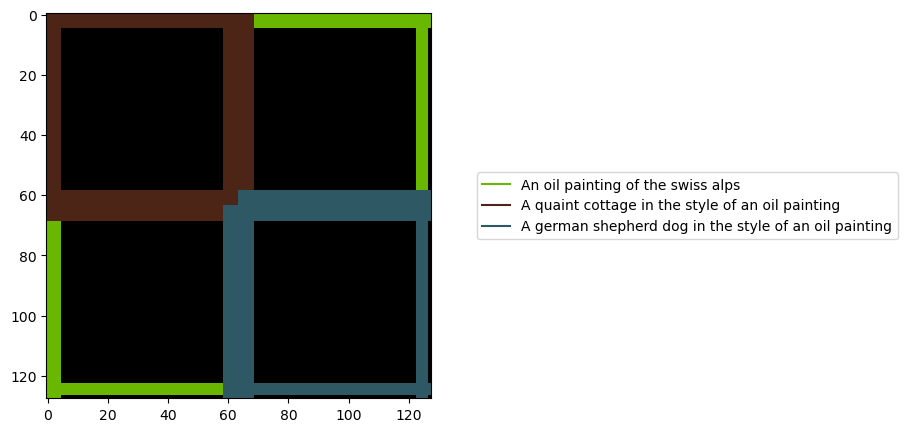

In [63]:
import matplotlib.pyplot as plt

guidance_mag = 20.0

# Specify the locations of textual descriptions to compose
# The keys have the form (scale, x, y) where scale is the size of the canvas and x, y is the starting locations

# context = {
#     (2, 0, 0): {
#         'string': 'An epic space battle',
#         'magnitude': guidance_mag
#     },
#     (1, 0, 0): {
#         'string': 'The starship Enterprise',
#         'magnitude': guidance_mag
#     },
#     # (1, 64, 64): {
#     #     'string': 'A star destroyer from Star Wars',
#     #     'magnitude': guidance_mag
#     # },
# }

context = {
    (2, 0, 0): {
        'string': "An oil painting of the swiss alps",
        'magnitude': guidance_mag
    },
    (1, 0, 0): {
        # 'string': "An oil painting of a quaint cottage",
        'string': "A quaint cottage in the style of an oil painting",
        'magnitude': guidance_mag
    },
    (1, 64, 64): {
        # "string": "An oil painting of a german shepherd",
        "string": "A german shepherd dog in the style of an oil painting",
        "magnitude": guidance_mag
    }
}

# context = {
#     (2, 0, 0):{'string':'A fantasy landscape, wallpaper, concept art, extremely detailed', 'magnitude':guidance_mag},
#     (1, 60, 60):{'string':'a blue lake, fantasy, wallpaper, extremely detailed', 'magnitude':guidance_mag},
#     (1, 20, 20):{'string':'A fancy castle, fantasy, wallpaper, extremely detailed', 'magnitude':guidance_mag},
# }

color_lookup = {}
np.random.seed(1)
for k, v in context.items():
    color_lookup[v['string']] = (np.random.uniform(size=(3, )), k[0]**2)

plt.figure(figsize=(5, 5))
img = visualize_context(128, 64, context, color_lookup)

plt.imshow(img)

for k, v in context.items():
    scale, xstart, ystart = k
    caption = v['string']
    color = color_lookup[caption][0]
    plt.plot([], [], color=color, label=caption)

plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

plt.savefig('composite_captions.pdf', bbox_inches='tight')
plt.savefig('composite_captions.png', bbox_inches='tight', facecolor=plt.gca().get_facecolor())
# %download_file composite_captions.pdf
# %download_file composite_captions.png

In [64]:
# !conda install xformers -c xformers

import torch

from PIL import Image
from torch import autocast

from diffusers import DDIMScheduler

has_cuda = torch.cuda.is_available()
device = torch.device('cpu' if not has_cuda else 'cuda')
print(device)

# initialize model
stage_1 = IFPipeline.from_pretrained("DeepFloyd/IF-I-XL-v1.0",
                                     variant="fp16",
                                     torch_dtype=torch.float16,
                                     use_auth_token=True)
stage_1.enable_xformers_memory_efficient_attention()
stage_1.enable_model_cpu_offload()
stage_1.safety_checker = None

# stage_2 = DiffusionPipeline.from_pretrained("DeepFloyd/IF-II-L-v1.0", text_encoder=None, variant="fp16", torch_dtype=torch.float16, use_auth_token=True)
# stage_2.enable_model_cpu_offload()
# stage_1.scheduler = DDIMScheduler.from_config(stage_1.scheduler.config)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.
Keyword arguments {'use_auth_token': True} are not expected by IFPipeline and will be ignored.


cuda


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [65]:
num_steps = 1000

# increase the number of Langevin MCMC steps run to sample between intermediate distributions
# more steps improves sampling quality
# la_steps = 10
# la_steps = 15
la_steps = 20

la_step_sizes = stage_1.scheduler.betas * 2

alphas = 1 - stage_1.scheduler.betas
alphas_cumprod = np.cumprod(alphas)
scalar = np.sqrt(1 / (1 - alphas_cumprod))

la_sampler = AnnealedULASampler(num_steps, la_steps, la_step_sizes, None, None, None)

In [66]:
import torch as th
from IPython.display import display

seed = 0
# Number of intermediate transition distributions to specify
steps = 100

generator = th.Generator('cuda').manual_seed(seed)

with th.no_grad():
    latents = stage_1(context,
                      la_sampler,
                      height=128,
                      width=128,
                      generator=generator,
                      num_inference_steps=steps)

/tmp/ipykernel_3641091/3004793477.py:538: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn(BACKENDS_MAPPING["bs4"][-1].format("Setting `clean_caption=True`"))

Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

/tmp/ipykernel_3641091/3004793477.py:539: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn("Setting `clean_caption` to False...")
Setting `clean_caption` to False...



Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...


  0%|          | 0/100 [00:00<?, ?it/s]

254.99948
0.00051677227


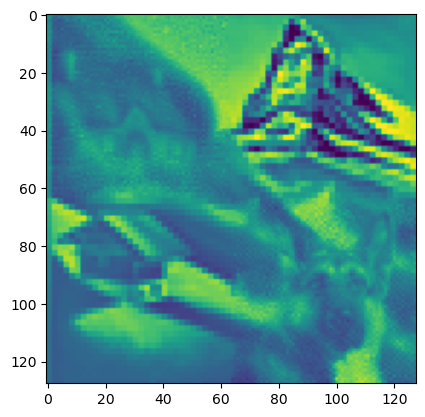

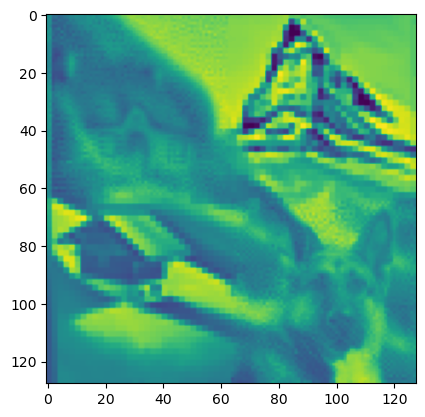

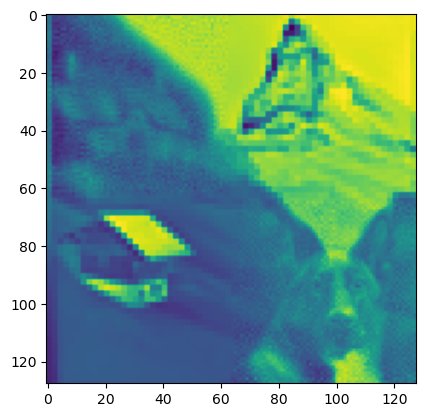

In [67]:
image = latents[0].cpu().numpy().transpose(1, 2, 0)
image = ((image + 1) / 2 * 255)

print(image.max())
print(image.min())

plt.figure()
plt.imshow(image[..., 0])

plt.figure()
plt.imshow(image[..., 1])

plt.figure()
plt.imshow(image[..., 2])

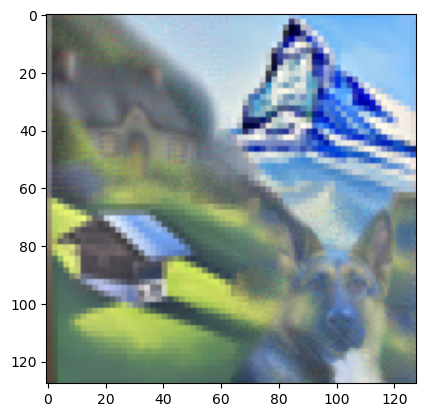

In [68]:
import matplotlib.pyplot as plt
# from imageio import imwrite

image = latents[0].cpu().numpy().transpose(1, 2, 0)
image = ((image + 1) / 2 * 255)

CLIP_DYNAMIC_RANGE = True
if CLIP_DYNAMIC_RANGE:
    image[image < 0.0] = 0.0
    image[image > 255] = 255

image = image.astype(np.uint8)
# imwrite("test.png", image)
plt.imshow(image)

In [69]:
stage_2 = DiffusionPipeline.from_pretrained("DeepFloyd/IF-II-L-v1.0",
                                            text_encoder=None,
                                            variant="fp16",
                                            torch_dtype=th.float16)
stage_2.enable_xformers_memory_efficient_attention()
stage_2.enable_model_cpu_offload()


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [70]:
prompt = ""
prompt_embeds, negative_embeds = stage_1.encode_prompt(prompt)
images = stage_2(image=latents,
                 prompt_embeds=prompt_embeds,
                 negative_prompt_embeds=negative_embeds,
                 generator=generator,
                 output_type="pt").images


  0%|          | 0/50 [00:00<?, ?it/s]

0.0
255.0


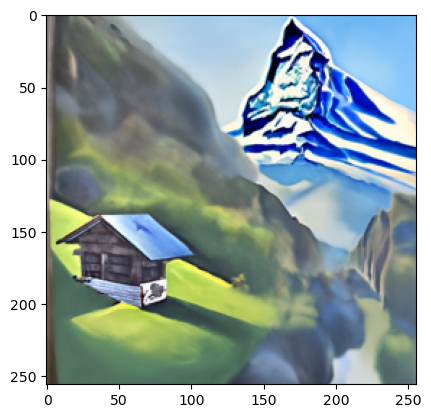

In [71]:
# save upsampled image
if not isinstance(images, np.ndarray):
    images = images[0].cpu().numpy().transpose(1, 2, 0)
    images = ((images + 1) / 2 * 255)

print(images.min())
print(images.max())

# if CLIP_DYNAMIC_RANGE:
# images[image]

images = images.astype(np.uint8)
plt.imshow(images)

In [44]:
np.save("oil_painting_swiss_alps_no_composed_diffusion.npy", images)